In [ ]:
import Pkg; Pkg.add("JSON")

In [ ]:
Pkg.add("Plots")

In [8]:
using JSON
using(Plots)

In [9]:
using BenchmarkTools

In [10]:
#include("./graph_force.jl")

In [11]:
struct Graph
    chains
    nodes
    coords
end

function printinfo(x::Graph)
    println(length(x.nodes), " nodes")
    println(length(x.chains), " chains")
    end;

# Search for intersections
# i.e. nodes which are in more than 1 chain
function search_intersections(graph)
    intersections = Dict()
    for (ch_idx, ch) in enumerate(graph.chains), n in ch
        el = get!(intersections, n, Int64[])
        push!(el, ch_idx)
        end;

    filter!(x -> length(x[2]) > 1, intersections);
    return intersections
    end;

# Search for intersecting chains
# i.e. returns index of the crossed chains
function search_chain_intersected(graph, chain_id)
    chain = graph.chains[chain_id]
    intersections = search_intersections(graph)
    intersected = Set{Int64}()
    for n in chain
        union!(intersected, get(intersections, n, []))
        end;
    setdiff!(intersected, chain_id)
    return collect(intersected)
    end;


In [12]:
function get_coords(graph, n)
    return graph.coords[[1, 2], graph.nodes[n]]
    end;

In [77]:
# Lagrange interpolation
function Lagrange_interpolation(knots, new_x)
    quotient(j, x, m) = if (j != m); (x - knots[m][1])/(knots[j][1] - knots[m][1]) else 1 end;
    el(j, x) = prod(m -> quotient(j, x, m), 1:length(knots))
    L(x) = sum(j -> knots[j][2].*el(j, x), 1:length(knots))
    return L.(new_x);
    end;

# test
#x = range(1, 6, step=1)
#Lagrange_interpolation([(3, [2, 2]), (5, [3, 4])], x)

# Place the first chain
# Returns a new graph (with one chain)
function init_graph(first_chain) 

    node_distance = 1.0
    nodes =  Dict(n => i
                    for (i, n) in enumerate(first_chain))
    coords = hcat([[node_distance*(i-1); 0] for i in 1:length(nodes)]...)
    return Graph([first_chain], nodes, coords)
    end;

# Add a chain to the graph
function add_a_chain!(graph, chain)
    # Search for knots, i.e. nodes already in the new graph
    knots = filter(x -> x in keys(graph.nodes), chain)

    println("number of knots: ", length(knots))
    if length(knots)==0;  error("zero intersection") end;

    # convert knots to [(position, Coords), ...]
    knots = map(n->(findfirst(isequal(n), chain), get_coords(graph, n)),  knots)

    # si un seul noeud...
    # choisir une direction "perpendiculaire"
    # cas si une seule chaine rencontrée
    # find nodes avant et après de cette chaine rencontrée
    if length(knots)==1
        idx_along_chain = knots[1][1]
        n = chain[idx_along_chain]

        other_chain_id = findfirst(ch -> n in ch, graph.chains)
        other_chain = graph.chains[other_chain_id]
        idx_along_other_chain = findfirst(isequal(n), other_chain)

        println("intersection with chain #", other_chain_id,
            " at node #", idx_along_other_chain)

        # Define a normal direction
        # take next or previous node (edge cases)
        if idx_along_other_chain == 1
            before = get_coords(graph, other_chain[1])
            next = get_coords(graph, other_chain[2])
        else
            before = get_coords(graph, other_chain[idx_along_other_chain-1])
            next = get_coords(graph, other_chain[idx_along_other_chain])
            end;

        # normal direction:
        u = next .- before
        norm = sqrt(u[1]^2 + u[2]^2) *.87242*length(chain)  # hack to prevent overlaping
        direction = [u[2]/norm; -u[1]/norm]

        # ajoute un noeud
        # si ce n'est pas le dernier alors le suivant
        # sinon le precedent
        # TODO: make a random choice, left or right?
        coords_n = knots[1][2]
        if idx_along_chain < length(chain)
            push!(knots, (idx_along_chain+1, coords_n .+ direction))
        else
            push!(knots, (idx_along_chain-1, coords_n .- direction))
            end;
        end;

    # Interpolation
    x = range(1, length(chain), step=1)
    coords = Lagrange_interpolation(knots, x)
    
    # update graph ... no
    push!(graph.chains, chain)
    for (i, (n, xy)) in enumerate(zip(chain, coords))
        println(xy)
        #push!(graph.coords, xy)
        graph.nodes[n] = length(graph.coords)
        end;
    end;

In [78]:
# Graph the graph
function graphplot(graph::Graph)
    fig = plot(legend=false, aspect_ratio=:equal)
    #scatter!(coords[:, 1], coords[:, 2], linewidth=2)
    for chain in graph.chains
        chain_xy = map(x -> graph.coords[[1, 2], graph.nodes[x]], chain);
        x = getindex.(chain_xy, 1)
        y = getindex.(chain_xy, 2)
        plot!(x, y, linewidth=3)
        #println(coords[idx, 1])
        end;
    fig
    end;

In [79]:
# Load graph from Json
files = filter(x -> endswith(x, ".json"), readdir("json/"))

1-element Array{String,1}:
 "197626394_228.json"

In [80]:
path = string("./json/", files[1])
data = read(path, String)
d = []
chains = JSON.parse( data, dicttype=Array{Array{String}});
sort!(chains, by=x->length(x), rev=true)
println(length(chains[1]))

33


In [81]:
# Define the (entire) graph
nodes_list = unique(n for ch in chains for n in ch)
nodes = Dict( n=>k for (k, n) in enumerate(nodes_list) )

fullgraph = Graph(chains, nodes, nothing);
printinfo(fullgraph)

255 nodes
38 chains


In [82]:
intersections = search_intersections(fullgraph)
println(length(intersections), " intersections")

49 intersections


In [83]:
# Start building the new graph
graph = init_graph(fullgraph.chains[1]);
added_chain = [1, ]
chains_to_add = search_chain_intersected(fullgraph, 1);
println("next: ", chains_to_add)

next: [25, 35]


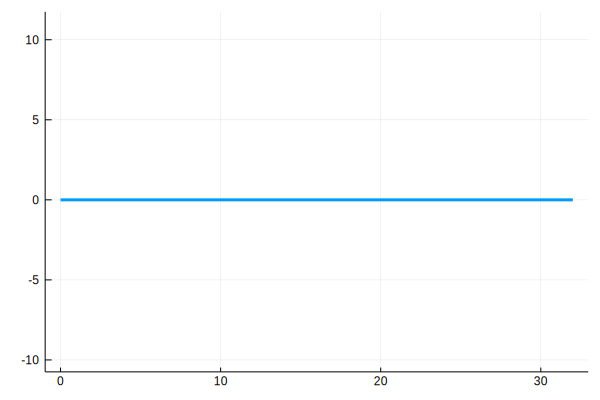

In [84]:
graphplot(graph)

In [85]:
function loop!(graph)
    
    next_chain_id = pop!(chains_to_add)
    next_chain = fullgraph.chains[next_chain_id]
    println("add chain #", next_chain_id, " of length ", length(next_chain))
    add_a_chain!(graph, next_chain)

    # update records
    push!(added_chain, next_chain_id)
    println("added chain ", added_chain, " check ", length(graph.chains))

    new_chains_to_add = search_chain_intersected(fullgraph, next_chain_id);
    println("all new chain ", new_chains_to_add)
    append!(chains_to_add, filter(x -> ~(x in added_chain)&~(x in chains_to_add), new_chains_to_add))
    sort!(chains_to_add, by=x->length(fullgraph.chains[x]), rev=false)
    println("chains_to_add  ", chains_to_add)
    
    println(length(graph.nodes), " nodes/ ", length(fullgraph.nodes))
    # Optimize
    #graph = run_optimiz(graph);
    graphplot(graph)

    # loop
    end;

In [90]:
?hcat!

search: hcat hvcat MathConstants search_chain_intersected

Couldn't find hcat!
Perhaps you meant hcat, hvcat, cat, vcat, hspan!, hash, path, coth or acoth


No documentation found.

Binding `hcat!` does not exist.


In [88]:
vcat!(graph.coords, [1; 2])

MethodError: MethodError: no method matching push!(::Array{Float64,2}, ::Array{Int64,1})
Closest candidates are:
  push!(::Any, ::Any, !Matched::Any) at abstractarray.jl:2159
  push!(::Any, ::Any, !Matched::Any, !Matched::Any...) at abstractarray.jl:2160
  push!(!Matched::Array{Any,1}, ::Any) at array.jl:875
  ...

In [86]:
loop!(graph)

add chain #35 of length 2
number of knots: 1
intersection with chain #1 at node #25
[24.0, 0.0]
[24.0, -0.5731184521216846]
added chain [1, 35] check 2
all new chain [22, 1]
chains_to_add  [25, 22]
34 nodes/ 255


BoundsError: BoundsError: attempt to access 2×33 Array{Float64,2} at index [[1, 2], 66]

In [55]:
length(graph.nodes)

33

In [56]:
graph.coords

2×33 Array{Float64,2}:
 0.0  1.0  2.0  3.0  4.0  5.0  6.0  …  27.0  28.0  29.0  30.0  31.0  32.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0   0.0

In [ ]:
using Profile